In [1]:
import pybaseball as pyb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# 구속과 스핀 효과

공의 구속과 스핀이 투구 결과에 미치는 영향을 확인해보았다. 

### **- [지표 계산](#calculate)**
- 스핀 효율(Spin Efficiency) 계산
- 헛스윙 비율(Whiff %) 계산
- 타구 타입 비율(Batted-Ball Type %) 계산
    - 땅볼(Ground ball)
    - 뜬공(Fly ball)
    - 라인드라이브(Line drive)
        

#### **1. 스핀 효율 분포와 스핀 효율에 따른 무브먼트**
- 공의 스핀 효율 분포에 대해 시각화하였다. 이를 통해 구종별 공의 회전이 무브먼트에 얼마나 영향을 미치는지 알 수 있었다. 평균적으로 패스트볼은 높은 스핀 효율을 가지고 있었고, 슬라이더는 낮은 스핀 효율을 가지고 있었다. 효율 분포도 옆에 스핀 효율에 따른 공의 무브먼트를 시각화하였다. 스핀 효율이 낮은 투구는 무브먼트가 원점에 가까운데 반면, 스핀 효율이 커질수록 무브먼트가 커지는 것을 확인할 수 있었다. 


#### **2. Whiff %**
- 구속과 스핀이 헛스윙율(Whiff %)에 미치는 영향을 확인하기 위해 히트맵으로 표현하였다. 구속은 1자리수까지 반올림한 정수 그룹으로 나누었고, 스핀은 100자리까지 반올림한 정수 그룹으로 분류하여, 각 그룹에 포함된 투구의 헛스윙율을 히트맵으로 시각화하였다.
- 구종별 트루 스핀(무브먼트에 영향을 주는 스핀)이 헛스윙율(Whiff %)와 상관 관계가 있는지 분석하였다. 스핀과 더불어 공 속도와 바우어 유닛(Bauer Unit: 스핀/속도)이 Whiff %에 영향을 미치는지 체크해보았다. 산점도로 데이터 간의 관계를 시각적으로 파악하고, 선형 회귀 분석을 수행하였다. 독립 변수들로는 공의 속도, 트루 스핀, 바우어 유닛으로 설정하였고, 종속 변수는 Whiff %로 하여 회귀 계수와 통계적 유의성을 해석하였다.
       
              
#### **3. Ground Ball %,  Fly Ball %**
- 구종별 공의 트루 스핀, 속도, 바우어 유닛이 땅볼과 뜬공 비율에 영향을 미치는지 분석하였다. 산점도로 확인해보면 구종별 지표별 차이는 있었지만, 흥미로운 결과를 얻을 수 있었다. 구종별 구속이나 트루 스핀, BA에 따라 땅볼 비율이 커지거나 작아지고, 반대로 뜬공 비율이 작아지거나 커지는 모습을 확인할 수 있었다. 이 결과로 인해 투수가 던지는 공의 특성(속도, 스핀, BA 등)이 타구의 성향(땅볼, 뜬공)을 짐작하는 데 도움이 될 수 있다는 결과를 얻을 수 있었다. 


### **- [포심 패스트볼](#4-seam)**



### **- [싱커](#sinker)**

       
       
### **- [커브](#curve)**



### **- [슬라이더](#slider)**


----

In [2]:
df = pyb.statcast('2019-04-01', '2021-10-03')

This is a large query, it may take a moment to complete


  0%|          | 0/513 [00:00<?, ?it/s]

Skipping offseason dates
Skipping offseason dates


100%|██████████| 513/513 [06:42<00:00,  1.27it/s]


In [3]:
df['month'] = df['game_date'].astype('str').str[:7]

<a id="calculate"></a>
# 0. 지표 계산

## Spin Efficiency Calculate

statcast 데이터를 이용해서 각 투구의 스핀 효율을 계산하였다. 계산에 사용된 변수들을(바람, 온도, 습도) 모두 상수로 가정하여 계산하였기 때문에 실제 스핀 효율과 차이가 있을 수 있다.

참조: http://baseball.physics.illinois.edu/trackman/SpinAxis.pdf

In [4]:
mass=5.125
circ=9.125
rho_1=0.075
K = 0.07182*rho_1*(5.125/mass)*((circ/9.125)**2)

df['yR'] = 60.5-df['release_extension']
df['tR'] = (df['vy0']*(-1) - np.sqrt(df['vy0']**2-2*df['ay']*(50-df['yR'])))/df['ay']
df['vxR'] = df['vx0']+df['ax']*df['tR']
df['vyR'] = df['vy0']+df['ay']*df['tR']
df['vzR'] = df['vz0']+df['az']*df['tR']
df['dv0'] = df['release_speed']-np.sqrt(df['vxR']**2+df['vyR']**2+df['vzR']**2)/1.467

df['tf'] = ((-1)*df['vyR']-np.sqrt(df['vyR']**2-2*df['ay']*(df['yR']-17/12)))/df['ay']
df['calculated_x_mvt'] = df['plate_x']-df['release_pos_x']-(df['vxR']/df['vyR'])*(17/12-df['yR'])
df['calculated_z_mvt'] = df['plate_z']-df['release_pos_z']-(df['vzR']/df['vyR'])*(17/12-df['yR'])+0.5*32.174*(df['tf']**2)

df['vxbar']= (2*df['vxR'] + df['ax']*df['tf'])/2
df['vybar']= (2*df['vyR'] + df['ay']*df['tf'])/2
df['vzbar']= (2*df['vzR'] + df['az']*df['tf'])/2
df['vbar'] = np.sqrt(df['vxbar']**2+df['vybar']**2+df['vzbar']**2)

df['adrag'] = (-1)*(df['ax']*df['vxbar']+df['ay']*df['vybar']+(df['az']+32.174)*df['vzbar'])/df['vbar']
df['amagx'] = df['ax'] + df['adrag']*df['vxbar']/df['vbar']
df['amagy'] = df['ay'] + df['adrag']*df['vybar']/df['vbar']
df['amagz'] = df['az'] + df['adrag']*df['vzbar']/df['vbar']+32.174
df['amag'] = np.sqrt(df['amagx']**2+df['amagy']**2+df['amagz']**2)

df['Mx'] = 0.5*df['amagx']*(df['tf']**2)*12
df['Mz'] = 0.5*df['amagz']*(df['tf']**2)*12

df['Cd']=df['adrag']/(K*(df['vbar']**2))
df['Cl']=df['amag']/(K*(df['vbar']**2))
df['S']=0.166*np.log(0.336/(0.336-df['Cl']))

df['spinT']=78.92*df['S']*df['vbar']
df['spinTX']=df['spinT']*(df['vybar']*df['amagz']-df['vzbar']*df['amagy'])/(df['amag']*df['vbar'])
df['spinTY']=df['spinT']*(df['vzbar']*df['amagx']-df['vxbar']*df['amagz'])/(df['amag']*df['vbar'])
df['spinTZ']=df['spinT']*(df['vxbar']*df['amagy']-df['vybar']*df['amagx'])/(df['amag']*df['vbar'])

df['spin-check'] = np.sqrt(df['spinTX']**2+df['spinTY']**2+df['spinTZ']**2)-df['spinT']
df['phi'] = np.where(df['amagz']>0, np.arctan2(df['amagx'], df['amagz'])*(180/np.pi)+90, 360+np.arctan2(df['amagx'], df['amagz'])*(180/np.pi)+90)
df['spin_eff'] = df['spinT']/df['release_spin_rate']
df['theta'] = np.where(df['spin_eff']<=1, np.arccos(df['spin_eff'])*180/np.pi, '')

## Whiff % Calculate

In [5]:
swing = ['hit_into_play', 'foul', 'swinging_strike', 'foul_tip', 'swinging_strike_blocked']
miss = ['swinging_strike', 'foul_tip', 'swinging_strike_blocked']
pitch_list = ['4-Seam Fastball', 'Sinker', 'Curveball', 'Slider']
whiff_df = pd.DataFrame()

for i in pitch_list:
    p_type = df[(df['pitch_name']==i)&(df['spin_eff']<=1)]
    p_type['swing'] = np.where(p_type['description'].isin(swing),1,0)
    p_type['miss'] = np.where(p_type['description'].isin(miss),1,0)
    p_type_whiff = p_type.groupby(['month', 'player_name', 'pitch_name']).agg({
        'pitch_type': 'count',
        'release_spin_rate': 'mean',
        'release_speed': 'mean',
        'spinT': 'mean',
        'pfx_x': 'mean',
        'pfx_z': 'mean',
        'spin_eff': 'mean',
        'swing': 'sum',
        'miss': 'sum'
    }).reset_index()
    p_type_whiff['gyro_spin'] = np.sqrt(p_type_whiff['release_spin_rate']**2 - p_type_whiff['spinT']**2)
    p_type_whiff['BU'] = p_type_whiff['release_spin_rate']/p_type_whiff['release_speed']
    p_type_whiff['swstr_per'] = round((p_type_whiff['miss']/p_type_whiff['pitch_type'])*100,2)
    p_type_whiff['whiff_per'] = round((p_type_whiff['miss']/p_type_whiff['swing'])*100,2)
    whiff_df = pd.concat([whiff_df, p_type_whiff])

## BB_type % Calculate

In [6]:
df['ground_ball'] = np.where(df['bb_type']=='ground_ball',1,0)
df['fly_ball'] = np.where(df['bb_type']=='fly_ball',1,0)
df['line_drive'] = np.where(df['bb_type']=='line_drive',1,0)
df['popup'] = np.where(df['bb_type']=='popup',1,0)
bb_type_df = pd.DataFrame()

for i in pitch_list:
    type_df = df[(df['pitch_name']==i)&(df['spin_eff']<=1)]
    b_type = type_df.groupby(['game_year','player_name','pitch_name']).agg({
        'pitch_type': 'count',
        'release_spin_rate': 'mean',
        'release_speed': 'mean',
        'spinT': 'mean',
        'spin_eff': 'mean',
        'ground_ball': 'sum',
        'fly_ball': 'sum',
        'line_drive': 'sum',
        'popup': 'sum'
    }).reset_index()
    b_type['BU'] = b_type['release_spin_rate']/b_type['release_speed']
    b_type['gyro_spin'] = np.sqrt(b_type['release_spin_rate']**2 - b_type['spinT']**2)
    b_type['bb_total'] = b_type['ground_ball']+b_type['fly_ball']+b_type['line_drive']+b_type['popup']
    b_type['ground_ball_per'] = round((b_type['ground_ball']/b_type['bb_total'])*100,2)
    b_type['fly_ball_per'] = round((b_type['fly_ball']/b_type['bb_total'])*100,2)
    b_type['line_drive_per'] = round((b_type['line_drive']/b_type['bb_total'])*100,2)
    b_type['popup_per'] = round((b_type['popup']/b_type['bb_total'])*100.2)
    bb_type_df = pd.concat([bb_type_df, b_type])

----

<a id="4-seam"></a>
# 1. 포심패스트볼

In [7]:

ff_whiff = whiff_df[whiff_df['pitch_name']=='4-Seam Fastball']
ff_whiff['spins'] = (round(ff_whiff['release_spin_rate']).astype('str').str[:-4]+'00').astype('int')
ff_whiff['speeds'] = (round(ff_whiff['release_speed']).astype('str').str[:-2]).astype('int')
ff_whiff = ff_whiff[ff_whiff['release_speed']>=90]
whiff_group = ff_whiff.groupby(['spins', 'speeds'])['miss' ,'swing'].sum().reset_index()
whiff_group['perc'] = whiff_group['miss']/whiff_group['swing']
whiff_pivot = whiff_group.pivot_table(index='speeds', columns='spins', values='perc')
ff_bb_type = bb_type_df[bb_type_df['pitch_name']=='4-Seam Fastball']

### 1-1. 스핀 효율 분포, 스핀 효율에 따른 무브먼트

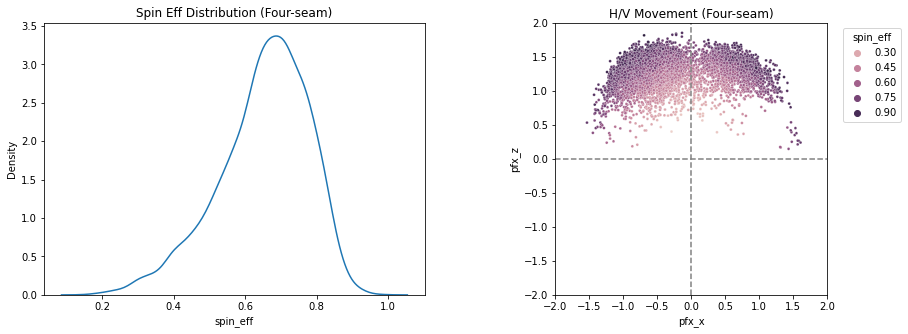

In [8]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(ff_whiff['spin_eff'], hist=False)
plt.title('Spin Eff Distribution (Four-seam)')

plt.subplot(1,2,2)
sns.scatterplot(x='pfx_x', y='pfx_z', data=ff_whiff, hue='spin_eff', s=8)
plt.axhline(0, linestyle='--', color='grey')
plt.axvline(0, linestyle='--', color='grey')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('H/V Movement (Four-seam)')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='spin_eff')
plt.gca().set_aspect('equal', adjustable='box')

### 1-2. ( Whiff % )  vs.  ( Velocity, True Spin, Bauer Unit )

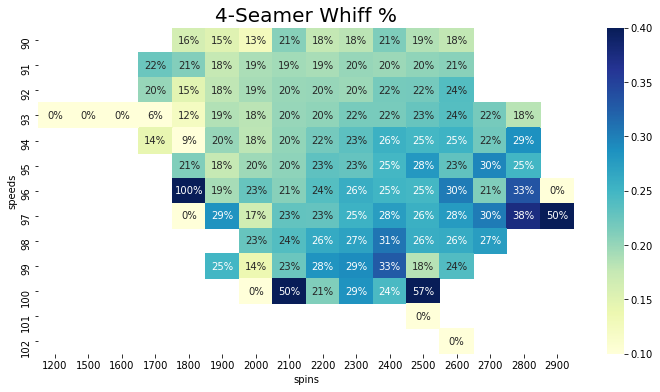

In [9]:
plt.figure(figsize=(12,6))
sns.heatmap(data=whiff_pivot,
            annot = True,
            fmt = '.0%',
            vmin=0.1,
            vmax=0.4,
            cmap = 'YlGnBu')
plt.title('4-Seamer Whiff %', size=20)
plt.show()

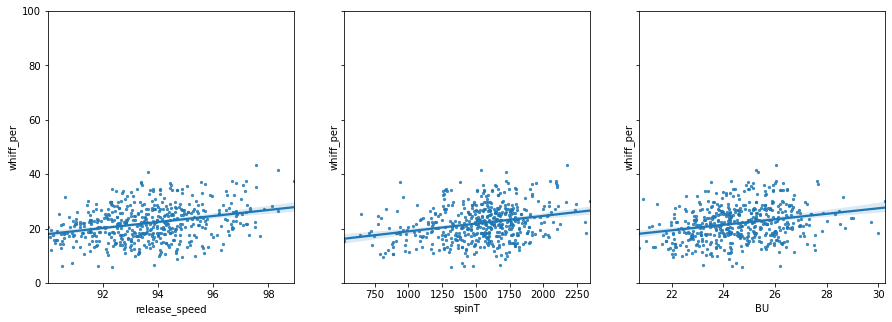

In [10]:
ff_whiff_50 = ff_whiff[ff_whiff['pitch_type']>=200]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,5))
sns.regplot(x='release_speed', y='whiff_per', data=ff_whiff_50, ax=ax1, scatter_kws={'s':5})
ax1.set_ylim([0, 100])
sns.regplot(x='spinT', y='whiff_per', data=ff_whiff_50, ax=ax2, scatter_kws={'s':5})
sns.regplot(x='BU', y='whiff_per', data=ff_whiff_50, ax=ax3, scatter_kws={'s':5})

plt.show()

In [11]:
import statsmodels.formula.api as smf

reg_1_1 = smf.ols(formula = 'whiff_per ~ release_speed + spinT + BU', data=ff_whiff_50).fit()
reg_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              whiff_per   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     38.81
Date:                Mon, 31 Jan 2022   Prob (F-statistic):           1.37e-22
Time:                        17:54:09   Log-Likelihood:                -1634.4
No. Observations:                 511   AIC:                             3277.
Df Residuals:                     507   BIC:                             3294.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -107.8879     14.908     -7.237      0.000    -137.177     -78.599
release_speed     1.0879      0.150      7.232      0.000       0.792       1.383
spinT             0.0036      0.001      4.012      0.000       0.002       0.005
BU                0.9115      0.173      5.283      0.000       0.573       1.251
==============================================================================
Omnibus:                        4.532   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                4.620
Skew:                           0.219   Prob(JB):                       0.0993
Kurtosis:                       2.841   Cond. No.                     8.88e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 1-3. ( GroundBall %, FlyBall % )  vs.  ( Velocity, True Spin, BU )

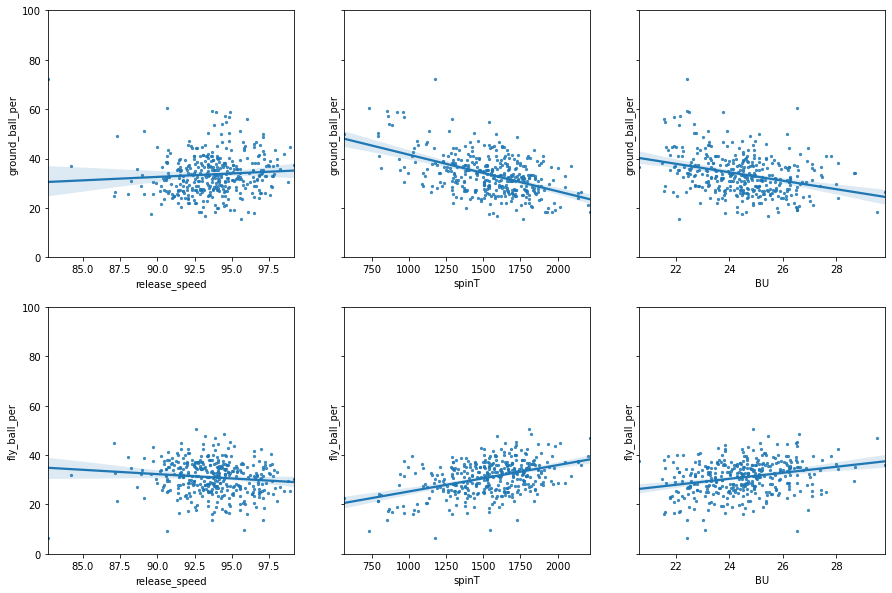

In [12]:
ff_bb_type_50 = ff_bb_type[ff_bb_type['pitch_type']>=500]

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(ncols=3, nrows=2,sharey=True, figsize=(15,10))
sns.regplot(x='release_speed', y='ground_ball_per', data=ff_bb_type_50, ax=ax1, scatter_kws={'s':5})
ax1.set_ylim([0, 100])
sns.regplot(x='spinT', y='ground_ball_per', data=ff_bb_type_50, ax=ax2, scatter_kws={'s':5})
sns.regplot(x='BU', y='ground_ball_per', data=ff_bb_type_50, ax=ax3, scatter_kws={'s':5})
sns.regplot(x='release_speed', y='fly_ball_per', data=ff_bb_type_50, ax=ax4, scatter_kws={'s':5})
sns.regplot(x='spinT', y='fly_ball_per', data=ff_bb_type_50, ax=ax5, scatter_kws={'s':5})
sns.regplot(x='BU', y='fly_ball_per', data=ff_bb_type_50, ax=ax6, scatter_kws={'s':5})
plt.show()

In [13]:
reg_1_2 = smf.ols(formula = 'ground_ball_per ~ release_speed + spinT + BU', data=ff_bb_type_50).fit()
reg_1_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ground_ball_per   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     61.07
Date:                Mon, 31 Jan 2022   Prob (F-statistic):           3.98e-32
Time:                        17:54:10   Log-Likelihood:                -1250.2
No. Observations:                 376   AIC:                             2508.
Df Residuals:                     372   BIC:                             2524.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        24.6829     16.176      1.526      0.128      -7.125      56.490
release_speed     0.6477      0.157      4.119      0.000       0.339       0.957
spinT            -0.0152      0.001    -11.254      0.000      -0.018      -0.013
BU               -1.1586      0.236     -4.906      0.000      -1.623      -0.694
==============================================================================
Omnibus:                       41.636   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.583
Skew:                           0.601   Prob(JB):                     9.58e-20
Kurtosis:                       5.036   Cond. No.                     7.26e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
reg_1_3 = smf.ols(formula = 'fly_ball_per ~ release_speed + spinT + BU', data=ff_bb_type_50).fit()
reg_1_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           fly_ball_per   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     44.90
Date:                Mon, 31 Jan 2022   Prob (F-statistic):           8.73e-25
Time:                        17:54:10   Log-Likelihood:                -1197.4
No. Observations:                 376   AIC:                             2403.
Df Residuals:                     372   BIC:                             2419.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        53.8173     14.059      3.828      0.000      26.173      81.462
release_speed    -0.6323      0.137     -4.627      0.000      -0.901      -0.364
spinT             0.0114      0.001      9.685      0.000       0.009       0.014
BU                0.7730      0.205      3.766      0.000       0.369       1.177
==============================================================================
Omnibus:                        9.653   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               11.106
Skew:                          -0.282   Prob(JB):                      0.00388
Kurtosis:                       3.626   Cond. No.                     7.26e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

----

<a id="sinker"></a>
# 2. 싱커

In [15]:
si = df[(df['pitch_name']=='Sinker') & (df['spin_eff']<=1)]
si_whiff = whiff_df[whiff_df['pitch_name']=='Sinker']
si_whiff['spins'] = (round(si_whiff['release_spin_rate']).astype('str').str[:-4]+'00').astype('int')
si_whiff['speeds'] = (round(si_whiff['release_speed']).astype('str').str[:-2]).astype('int')
si_whiff = si_whiff[si_whiff['release_speed']>=80]
si_whiff_group = si_whiff.groupby(['spins', 'speeds'])['miss' ,'swing'].sum().reset_index()
si_whiff_group['perc'] = si_whiff_group['miss']/si_whiff_group['swing']
si_whiff_pivot = si_whiff_group.pivot_table(index='speeds', columns='spins', values='perc')

si_bb_type = bb_type_df[bb_type_df['pitch_name']=='Sinker']

### 2-1. 스핀 효율 분포, 스핀 효율에 따른 무브먼트

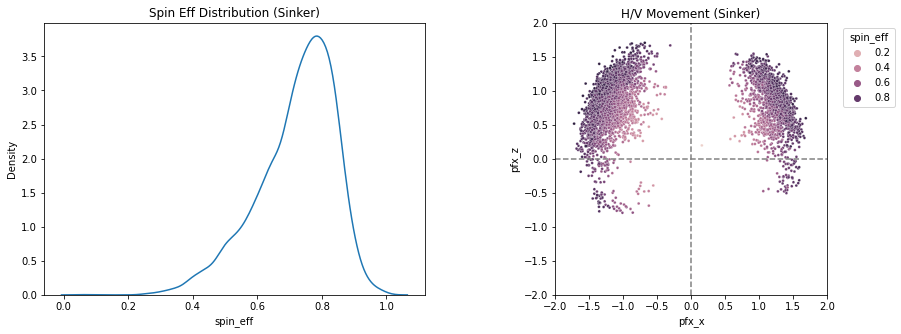

In [16]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(si_whiff['spin_eff'], hist=False)
plt.title('Spin Eff Distribution (Sinker)')

plt.subplot(1,2,2)
sns.scatterplot(x='pfx_x', y='pfx_z', data=si_whiff, hue='spin_eff', s=8)
plt.axhline(0, linestyle='--', color='grey')
plt.axvline(0, linestyle='--', color='grey')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('H/V Movement (Sinker)')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='spin_eff')
plt.gca().set_aspect('equal', adjustable='box')

### 2-2. ( Whiff % )  vs.  ( Velocity, True Spin, Bauer Unit )

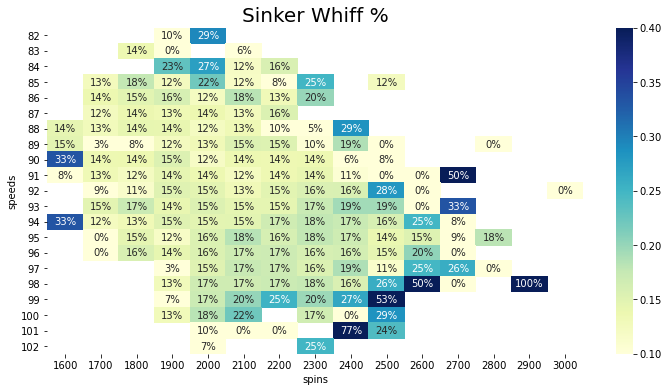

In [17]:
plt.figure(figsize=(12,6))
sns.heatmap(data=si_whiff_pivot,
            annot = True,
            fmt = '.0%',
            vmin=0.1,
            vmax=0.4,
            cmap = 'YlGnBu')
plt.title('Sinker Whiff %', size=20)
plt.show()

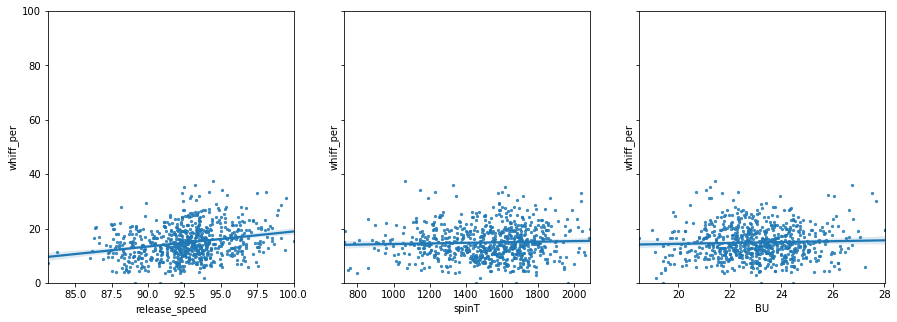

In [18]:
si_whiff_50 = si_whiff[si_whiff['pitch_type']>=100]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,5))
sns.regplot(x='release_speed', y='whiff_per', data=si_whiff_50, ax=ax1, scatter_kws={'s':5})
ax1.set_ylim([0, 100])
sns.regplot(x='spinT', y='whiff_per', data=si_whiff_50, ax=ax2, scatter_kws={'s':5})
sns.regplot(x='BU', y='whiff_per', data=si_whiff_50, ax=ax3, scatter_kws={'s':5})

plt.show()

#### 선형 회귀 분석

In [19]:
reg_2_1 = smf.ols(formula = 'whiff_per ~ release_speed + spinT + BU', data=si_whiff_50).fit()
reg_2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              whiff_per   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     16.88
Date:                Mon, 31 Jan 2022   Prob (F-statistic):           1.31e-10
Time:                        17:54:13   Log-Likelihood:                -2334.0
No. Observations:                 731   AIC:                             4676.
Df Residuals:                     727   BIC:                             4694.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -47.4671      8.950     -5.303      0.000     -65.039     -29.896
release_speed     0.6190      0.089      6.954      0.000       0.444       0.794
spinT            -0.0015      0.001     -1.600      0.110      -0.003       0.000
BU                0.3165      0.144      2.201      0.028       0.034       0.599
==============================================================================
Omnibus:                       38.184   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.813
Skew:                           0.570   Prob(JB):                     5.05e-10
Kurtosis:                       3.326   Cond. No.                     6.32e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 2-3. ( GroundBall %, FlyBall % )  vs.  ( Velocity, True Spin, BU )

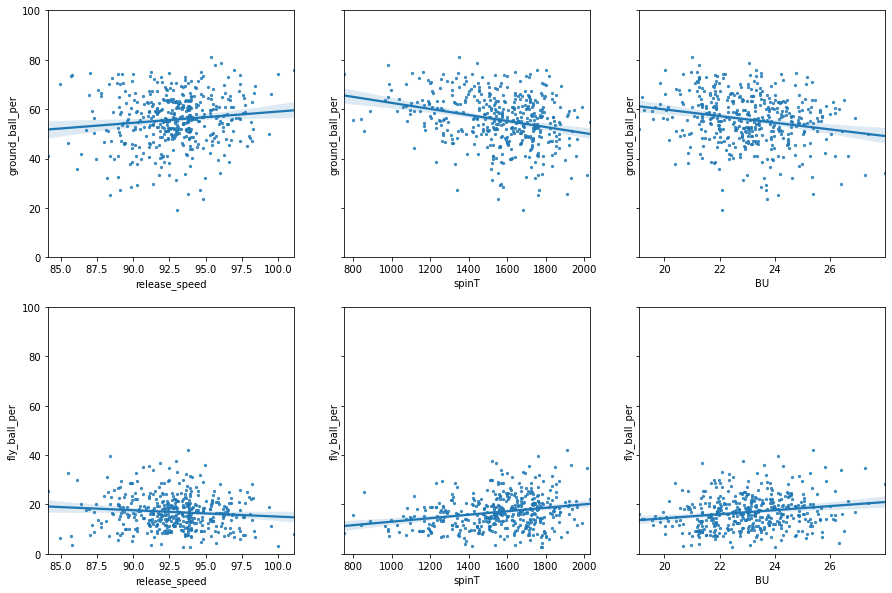

In [20]:
si_bb_type_50 = si_bb_type[si_bb_type['pitch_type']>=200]

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(ncols=3, nrows=2,sharey=True, figsize=(15,10))
sns.regplot(x='release_speed', y='ground_ball_per', data=si_bb_type_50, ax=ax1, scatter_kws={'s':5})
ax1.set_ylim([0, 100])
sns.regplot(x='spinT', y='ground_ball_per', data=si_bb_type_50, ax=ax2, scatter_kws={'s':5})
sns.regplot(x='BU', y='ground_ball_per', data=si_bb_type_50, ax=ax3, scatter_kws={'s':5})
sns.regplot(x='release_speed', y='fly_ball_per', data=si_bb_type_50, ax=ax4, scatter_kws={'s':5})
sns.regplot(x='spinT', y='fly_ball_per', data=si_bb_type_50, ax=ax5, scatter_kws={'s':5})
sns.regplot(x='BU', y='fly_ball_per', data=si_bb_type_50, ax=ax6, scatter_kws={'s':5})
plt.show()

#### 선형 회귀 분석

In [21]:
reg_2_2 = smf.ols(formula = 'ground_ball_per ~ release_speed + spinT + BU', data=si_bb_type_50).fit()
reg_2_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ground_ball_per   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     22.32
Date:                Mon, 31 Jan 2022   Prob (F-statistic):           1.94e-13
Time:                        17:54:15   Log-Likelihood:                -1588.0
No. Observations:                 430   AIC:                             3184.
Df Residuals:                     426   BIC:                             3200.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        15.8181     19.187      0.824      0.410     -21.896      53.532
release_speed     0.8646      0.191      4.521      0.000       0.489       1.241
spinT            -0.0147      0.002     -6.513      0.000      -0.019      -0.010
BU               -0.7555      0.315     -2.395      0.017      -1.375      -0.135
==============================================================================
Omnibus:                        9.200   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.589
Skew:                          -0.295   Prob(JB):                      0.00827
Kurtosis:                       3.432   Cond. No.                     6.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
reg_2_3 = smf.ols(formula = 'fly_ball_per ~ release_speed + spinT + BU', data=si_bb_type_50).fit()
reg_2_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           fly_ball_per   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     17.05
Date:                Mon, 31 Jan 2022   Prob (F-statistic):           1.78e-10
Time:                        17:54:15   Log-Likelihood:                -1411.2
No. Observations:                 430   AIC:                             2830.
Df Residuals:                     426   BIC:                             2847.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        37.8014     12.718      2.972      0.003      12.803      62.799
release_speed    -0.4857      0.127     -3.831      0.000      -0.735      -0.236
spinT             0.0084      0.002      5.577      0.000       0.005       0.011
BU                0.4864      0.209      2.326      0.020       0.075       0.897
==============================================================================
Omnibus:                       12.601   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.184
Skew:                           0.373   Prob(JB):                      0.00137
Kurtosis:                       3.422   Cond. No.                     6.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

----

<a id="curve"></a>
# 3. 커브볼

In [23]:
cu_whiff = whiff_df[whiff_df['pitch_name']=='Curveball']
cu_whiff['spins'] = (round(cu_whiff['release_spin_rate']).astype('str').str[:-4]+'00').astype('int')
cu_whiff['speeds'] = (round(cu_whiff['release_speed']).astype('str').str[:-2]).astype('int')
cu_whiff = cu_whiff[cu_whiff['release_speed']>=70]
cu_whiff_group = cu_whiff.groupby(['spins', 'speeds'])['miss' ,'swing'].sum().reset_index()
cu_whiff_group['perc'] = cu_whiff_group['miss']/cu_whiff_group['swing']
cu_whiff_pivot = cu_whiff_group.pivot_table(index='speeds', columns='spins', values='perc')

cu_bb_type = bb_type_df[bb_type_df['pitch_name']=='Curveball']

### 3-1. 스핀 효율 분포, 스핀 효율에 따른 무브먼트

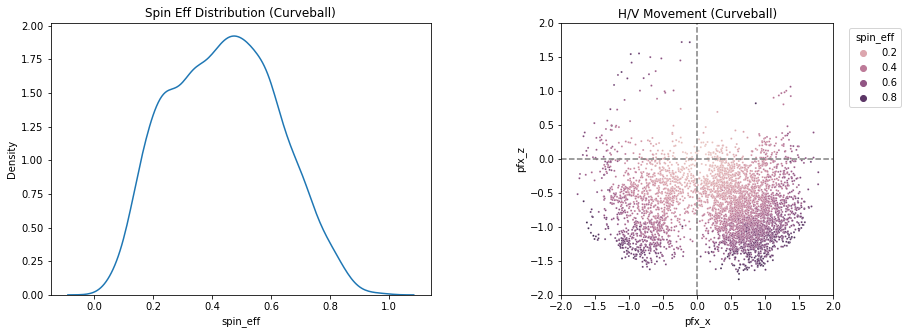

In [24]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(cu_whiff['spin_eff'], hist=False)
plt.title('Spin Eff Distribution (Curveball)')

plt.subplot(1,2,2)
sns.scatterplot(x='pfx_x', y='pfx_z', data=cu_whiff, hue='spin_eff', s=4)
plt.axhline(0, linestyle='--', color='grey')
plt.axvline(0, linestyle='--', color='grey')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('H/V Movement (Curveball)')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='spin_eff')
plt.gca().set_aspect('equal', adjustable='box')

### 3-2. ( Whiff % )  vs.  ( Velocity, True Spin, Bauer Unit )

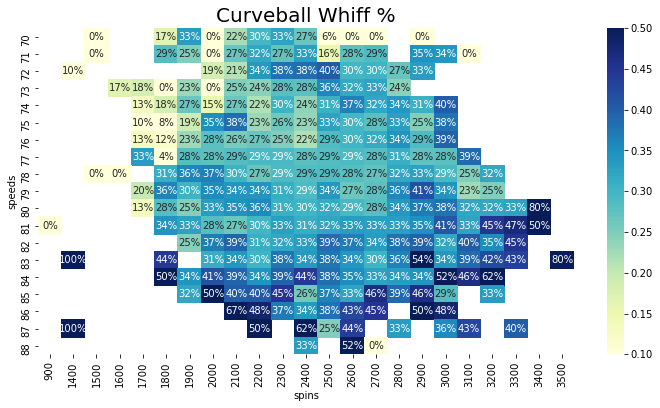

In [25]:
plt.figure(figsize=(12,6))
sns.heatmap(data=cu_whiff_pivot,
            annot = True,
            fmt = '.0%',
            vmin=0.1,
            vmax=0.5,
            cmap = 'YlGnBu')
plt.title('Curveball Whiff %', size=20)
plt.show()

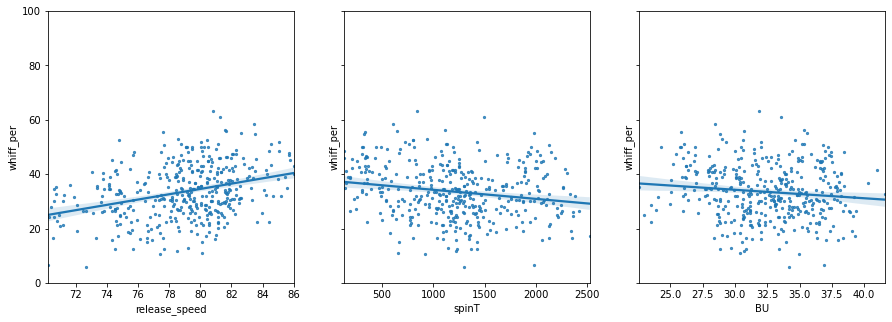

In [26]:
cu_whiff_50 = cu_whiff[cu_whiff['pitch_type']>=80]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,5))
sns.regplot(x='release_speed', y='whiff_per', data=cu_whiff_50, ax=ax1, scatter_kws={'s':5})
ax1.set_ylim([0, 100])
sns.regplot(x='spinT', y='whiff_per', data=cu_whiff_50, ax=ax2, scatter_kws={'s':5})
sns.regplot(x='BU', y='whiff_per', data=cu_whiff_50, ax=ax3, scatter_kws={'s':5})
plt.show()

In [27]:
reg_3_1 = smf.ols(formula = 'whiff_per ~ release_speed + spinT + BU', data=cu_whiff_50).fit()
reg_3_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              whiff_per   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     17.56
Date:                Mon, 31 Jan 2022   Prob (F-statistic):           1.00e-10
Time:                        17:54:18   Log-Likelihood:                -1466.0
No. Observations:                 401   AIC:                             2940.
Df Residuals:                     397   BIC:                             2956.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -44.4187     14.033     -3.165      0.002     -72.007     -16.830
release_speed     0.9211      0.152      6.050      0.000       0.622       1.220
spinT            -0.0026      0.001     -2.169      0.031      -0.005      -0.000
BU                0.2607      0.183      1.426      0.155      -0.099       0.620
==============================================================================
Omnibus:                        1.891   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.388   Jarque-Bera (JB):                1.781
Skew:                           0.081   Prob(JB):                        0.410
Kurtosis:                       2.717   Cond. No.                     4.02e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 3-3. ( GroundBall %, FlyBall % )  vs.  ( Velocity, True Spin, BU )

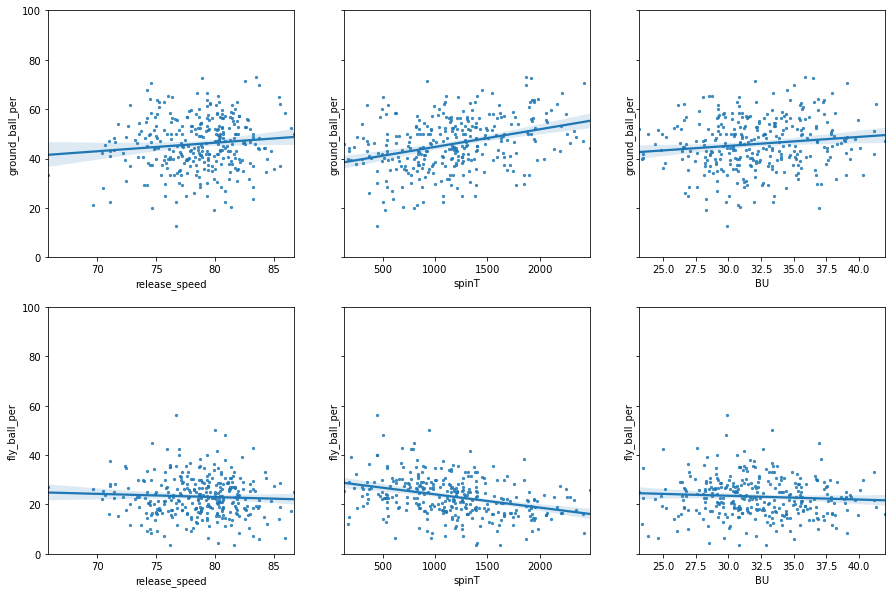

In [28]:
cu_bb_type_50 = cu_bb_type[cu_bb_type['pitch_type']>=150]

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(ncols=3, nrows=2,sharey=True, figsize=(15,10))
sns.regplot(x='release_speed', y='ground_ball_per', data=cu_bb_type_50, ax=ax1, scatter_kws={'s':5})
ax1.set_ylim([0, 100])
sns.regplot(x='spinT', y='ground_ball_per', data=cu_bb_type_50, ax=ax2, scatter_kws={'s':5})
sns.regplot(x='BU', y='ground_ball_per', data=cu_bb_type_50, ax=ax3, scatter_kws={'s':5})
sns.regplot(x='release_speed', y='fly_ball_per', data=cu_bb_type_50, ax=ax4, scatter_kws={'s':5})
sns.regplot(x='spinT', y='fly_ball_per', data=cu_bb_type_50, ax=ax5, scatter_kws={'s':5})
sns.regplot(x='BU', y='fly_ball_per', data=cu_bb_type_50, ax=ax6, scatter_kws={'s':5})
plt.show()

In [29]:
reg_3_2 = smf.ols(formula = 'ground_ball_per ~ release_speed + spinT + BU', data=cu_bb_type_50).fit()
reg_3_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ground_ball_per   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     22.07
Date:                Mon, 31 Jan 2022   Prob (F-statistic):           5.55e-13
Time:                        17:54:20   Log-Likelihood:                -1161.9
No. Observations:                 315   AIC:                             2332.
Df Residuals:                     311   BIC:                             2347.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -13.6600     15.542     -0.879      0.380     -44.240      16.920
release_speed     0.7397      0.173      4.270      0.000       0.399       1.081
spinT             0.0104      0.001      7.115      0.000       0.008       0.013
BU               -0.3339      0.191     -1.751      0.081      -0.709       0.041
==============================================================================
Omnibus:                        1.093   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.579   Jarque-Bera (JB):                1.200
Skew:                          -0.118   Prob(JB):                        0.549
Kurtosis:                       2.810   Cond. No.                     3.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
reg_3_3 = smf.ols(formula = 'fly_ball_per ~ release_speed + spinT + BU', data=cu_bb_type_50).fit()
reg_3_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           fly_ball_per   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     21.19
Date:                Mon, 31 Jan 2022   Prob (F-statistic):           1.62e-12
Time:                        17:54:20   Log-Likelihood:                -1076.5
No. Observations:                 315   AIC:                             2161.
Df Residuals:                     311   BIC:                             2176.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        48.0019     11.850      4.051      0.000      24.685      71.319
release_speed    -0.3853      0.132     -2.917      0.004      -0.645      -0.125
spinT            -0.0086      0.001     -7.698      0.000      -0.011      -0.006
BU                0.4824      0.145      3.318      0.001       0.196       0.769
==============================================================================
Omnibus:                       13.245   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.789
Skew:                           0.418   Prob(JB):                     0.000615
Kurtosis:                       3.655   Cond. No.                     3.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

----

<a id="slider"></a>
# 4. 슬라이더

In [31]:
sl_whiff = whiff_df[whiff_df['pitch_name']=='Slider']
sl_whiff['spins'] = (round(sl_whiff['release_spin_rate']).astype('str').str[:-4]+'00').astype('int')
sl_whiff['speeds'] = (round(sl_whiff['release_speed']).astype('str').str[:-2]).astype('int')
sl_whiff = sl_whiff[sl_whiff['release_speed']>=70]
sl_whiff_group = sl_whiff.groupby(['spins', 'speeds'])['miss' ,'swing'].sum().reset_index()
sl_whiff_group['perc'] = sl_whiff_group['miss']/sl_whiff_group['swing']
sl_whiff_pivot = sl_whiff_group.pivot_table(index='speeds', columns='spins', values='perc')
sl_bb_type = bb_type_df[bb_type_df['pitch_name']=='Slider']

### 4-1. 스핀 효율 분포, 스핀 효율에 따른 무브먼트

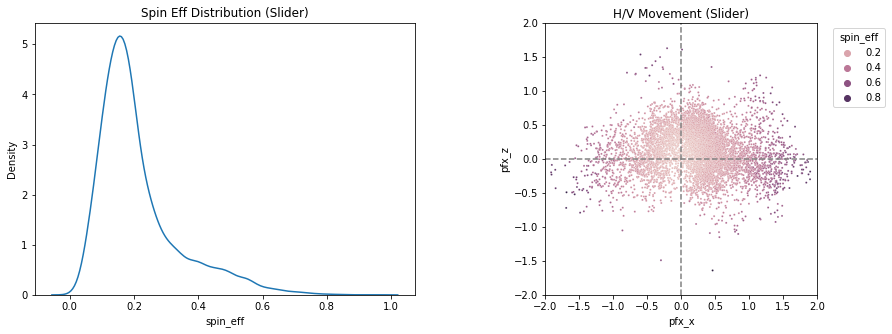

In [32]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(sl_whiff['spin_eff'], hist=False)
plt.title('Spin Eff Distribution (Slider)')

plt.subplot(1,2,2)
sns.scatterplot(x='pfx_x', y='pfx_z', data=sl_whiff, hue='spin_eff', s=4)
plt.axhline(0, linestyle='--', color='grey')
plt.axvline(0, linestyle='--', color='grey')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('H/V Movement (Slider)')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='spin_eff')
plt.gca().set_aspect('equal', adjustable='box')

### 4-2. ( Whiff % )  vs.  ( Velocity, True Spin, Bauer Unit )

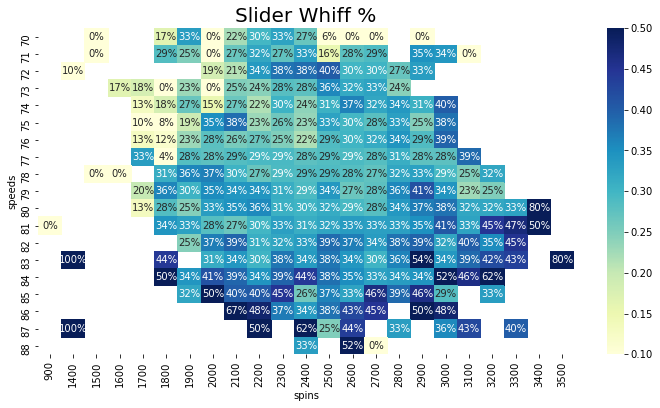

In [33]:
plt.figure(figsize=(12,6))
sns.heatmap(data=cu_whiff_pivot,
            annot = True,
            fmt = '.0%',
            vmin=0.1,
            vmax=0.5,
            cmap = 'YlGnBu')
plt.title('Slider Whiff %', size=20)
plt.show()

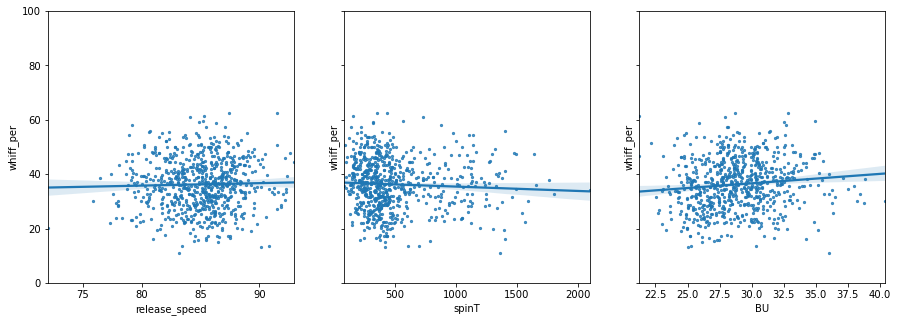

In [34]:
sl_whiff_50 = sl_whiff[sl_whiff['pitch_type']>=100]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,5))
sns.regplot(x='release_speed', y='whiff_per', data=sl_whiff_50, ax=ax1, scatter_kws={'s':5})
ax1.set_ylim([0, 100])
sns.regplot(x='spinT', y='whiff_per', data=sl_whiff_50, ax=ax2, scatter_kws={'s':5})

sns.regplot(x='BU', y='whiff_per', data=sl_whiff_50, ax=ax3, scatter_kws={'s':5})
plt.show()

In [35]:
reg_4_1 = smf.ols(formula = 'whiff_per ~ release_speed + spinT + BU', data=sl_whiff_50).fit()
reg_4_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              whiff_per   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     8.848
Date:                Mon, 31 Jan 2022   Prob (F-statistic):           9.19e-06
Time:                        17:54:23   Log-Likelihood:                -2598.1
No. Observations:                 714   AIC:                             5204.
Df Residuals:                     710   BIC:                             5222.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.7387     12.931      0.598      0.550     -17.649      33.127
release_speed     0.1161      0.134      0.865      0.387      -0.147       0.379
spinT            -0.0051      0.001     -3.628      0.000      -0.008      -0.002
BU                0.7335      0.149      4.924      0.000       0.441       1.026
==============================================================================
Omnibus:                        3.206   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.201   Jarque-Bera (JB):                3.161
Skew:                           0.127   Prob(JB):                        0.206
Kurtosis:                       2.795   Cond. No.                     2.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4-3. ( GroundBall %, FlyBall % )  vs.  ( Velocity, True Spin, BU )

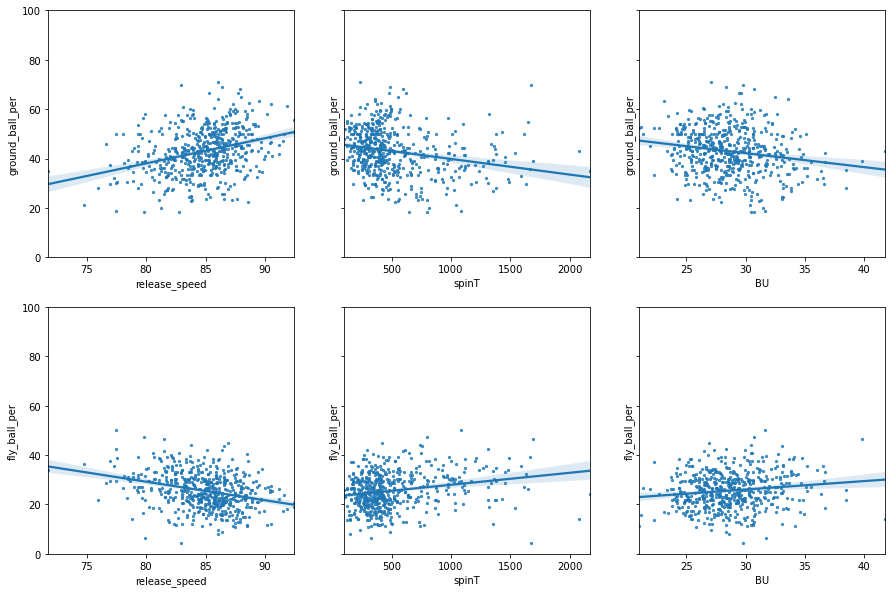

In [36]:
sl_bb_type_50 = sl_bb_type[sl_bb_type['pitch_type']>=200]

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(ncols=3, nrows=2,sharey=True, figsize=(15,10))
sns.regplot(x='release_speed', y='ground_ball_per', data=sl_bb_type_50, ax=ax1, scatter_kws={'s':5})
ax1.set_ylim([0, 100])
sns.regplot(x='spinT', y='ground_ball_per', data=sl_bb_type_50, ax=ax2, scatter_kws={'s':5})
sns.regplot(x='BU', y='ground_ball_per', data=sl_bb_type_50, ax=ax3, scatter_kws={'s':5})
sns.regplot(x='release_speed', y='fly_ball_per', data=sl_bb_type_50, ax=ax4, scatter_kws={'s':5})
sns.regplot(x='spinT', y='fly_ball_per', data=sl_bb_type_50, ax=ax5, scatter_kws={'s':5})
sns.regplot(x='BU', y='fly_ball_per', data=sl_bb_type_50, ax=ax6, scatter_kws={'s':5})
plt.show()

In [37]:
reg_4_2 = smf.ols(formula = 'ground_ball_per ~ release_speed + spinT + BU', data=sl_bb_type_50).fit()
reg_4_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ground_ball_per   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     21.37
Date:                Mon, 31 Jan 2022   Prob (F-statistic):           4.44e-13
Time:                        17:54:25   Log-Likelihood:                -1917.2
No. Observations:                 533   AIC:                             3842.
Df Residuals:                     529   BIC:                             3859.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -28.0511     14.779     -1.898      0.058     -57.084       0.982
release_speed     0.8753      0.156      5.628      0.000       0.570       1.181
spinT            -0.0018      0.002     -1.136      0.256      -0.005       0.001
BU               -0.0813      0.164     -0.497      0.620      -0.403       0.240
==============================================================================
Omnibus:                        1.352   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.509   Jarque-Bera (JB):                1.178
Skew:                           0.104   Prob(JB):                        0.555
Kurtosis:                       3.100   Cond. No.                     2.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
reg_4_3 = smf.ols(formula = 'fly_ball_per ~ release_speed + spinT + BU', data=sl_bb_type_50).fit()
reg_4_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           fly_ball_per   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     19.08
Date:                Mon, 31 Jan 2022   Prob (F-statistic):           9.20e-12
Time:                        17:54:25   Log-Likelihood:                -1788.0
No. Observations:                 533   AIC:                             3584.
Df Residuals:                     529   BIC:                             3601.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        81.6434     11.598      7.040      0.000      58.860     104.427
release_speed    -0.6462      0.122     -5.295      0.000      -0.886      -0.406
spinT             0.0023      0.001      1.845      0.066      -0.000       0.005
BU               -0.0832      0.128     -0.648      0.517      -0.336       0.169
==============================================================================
Omnibus:                        1.389   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.499   Jarque-Bera (JB):                1.202
Skew:                           0.063   Prob(JB):                        0.548
Kurtosis:                       3.196   Cond. No.                     2.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""